## DRL 코드입니다.
* 저는 이 코드와 제가 만든 환경을 가지고 학습을 했지만, 실제로는 OMNeT++와 이 이 코드를 연동시켜주셔야 합니다.
* 그러므로 제가 만든 환경 코드는 이해하실 필요가 없습니다. 이 코드의 DNN 구조와, 환경과 상호작용하는 인터페이스 부분만 참고해주시면 될 듯 합니다.
* main 부분은 아키텍처 설명한 ppt를 보시고 새로 짜시는게 더 빠를 수 있습니다.
* DQN based가 아닌, Policy gradient based인 actor-critic을 쓰고자 합니다(많은 스케줄링 관련 논문에서 actor-critic 사용. 또한 DQN은 규모가 좀 커지면 학습 힘들다고 알고 있음).
* actor-critic 알고리즘은 다양합니다. 저희는 A3C 혹은 PPO를 쓸 것 같습니다. 각 알고리즘에 대해선 논문을 읽어보시거나 검색하셔서 이해해주시면 될 것 같습니다.
* actor network로 GNN(Graph Neural Network)를 사용합니다. Pytorch geometric library에서 다양한 GNN 모듈을 제공합니다. 저희는 Dynamic edge-conditioned GNN을 씁니다.
* Dynamic edge-conditioned GNN : https://arxiv.org/abs/1704.02901
* 코드 기반 : https://github.com/seungeunrho/minimalRL/blob/master/ppo.py
* GNN 예제 : https://baeseongsu.github.io/posts/pytorch-geometric-introduction/
* GNN 배치 단위 inference 하는법 : https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
* 지금 이 코드는 돌아가긴 하지만, 학습이 제대로 안되는 상황입니다. 모든 state에 대해서 한 액션으로 거의 모든 확률이 쏠려버리게끔 학습이 되는데, 원인은 찾지 못했습니다. 아마 제가 만든 환경에 문제가 있을 수도 있고, 학습 자체를 더 튜닝해야 될 수도 있습니다.

In [5]:
import import_ipynb
from library import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch_geometric.nn import NNConv, global_mean_pool, GraphUNet
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
learning_rate   = 0.001
gamma           = 0.9
entropy_weight  = 0.1
'''
entropy_weight : loss함수에 entropy라는 걸 더해주는 테크닉에서의 weight입니다.
이 기법은 A3C 논문에 나와있으며, 쓰는 이유는 exploration을 촉진하기 위해서입니다.
각 액션을 취할 확률을 거의 균등하게끔 업데이트해줌으로써 다양한 액션을 해볼 기회가 많아집니다.
actor-critic에서 이 기법으로 인한 성능 개선이 매우 효과적인 것으로 알고있으므로, 적용해주시면 좋을 듯 합니다.
'''
lmbda         = 0.95
eps_clip      = 0.1
'''
위 두 인자는 PPO에서 씁니다.
'''

loss_coef = 0.5

node_feature_num = 100
queue_feature_num = 100

In [7]:
class actor_network(nn.Module):
    def __init__(self):
        super(actor_network, self).__init__()
        self.data = []

        self.pi_mlp1 = nn.Sequential(nn.Linear(1, node_feature_num * node_feature_num), nn.ReLU())
        self.pi_s_gcn = NNConv(node_feature_num, node_feature_num, self.pi_mlp1, aggr='mean')

        self.pi_graph_u_net = GraphUNet(node_feature_num, 10, node_feature_num, 4, 0.8)

        self.pi_backbone = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # prob_fc : 각 액션에 대한 확률.
        self.pi_prob_fc = nn.Linear(64, 5)

        self.v_mlp1 = nn.Sequential(nn.Linear(1, node_feature_num * node_feature_num), nn.ReLU())
        self.v_s_gcn = NNConv(node_feature_num, node_feature_num, self.v_mlp1, aggr='mean')

        self.v_graph_u_net = GraphUNet(node_feature_num, 10, node_feature_num, 4, 0.8)

        self.v_backbone = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # prob_fc : 각 액션에 대한 확률.
        self.v_value_fc = nn.Linear(64, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
              
        
    # policy DNN
    def pi(self, state):
        data, job_waiting_feature = state # data = graph data
        node_feature, link_feature, adjacency = data.x, data.edge_attr, data.edge_index
        """
        node_feature = F.relu(self.conv1(node_feature, adjacency, link_feature))
        node_feature = F.relu(self.conv2(node_feature, adjacency, link_feature))
        #node_feature = F.relu(self.conv3(node_feature, adjacency, link_feature))
        readout = global_mean_pool(node_feature, data.batch) # 모든 노드의 feature를 평균내서 하나의 벡터로 만들어주기.
        """

        node_feature = F.relu(self.pi_s_gcn(node_feature, adjacency, link_feature))
        node_feature = self.pi_graph_u_net(node_feature, adjacency)
        readout = global_mean_pool(node_feature, data.batch)
        print("readout", readout.shape)
        print("job_waiting_feature", job_waiting_feature.shape)
        concat = torch.cat([readout, job_waiting_feature], dim=1) # 여기에 job waiting 벡터 붙이기.

        feature_extract = self.pi_backbone(concat)

        output = self.pi_prob_fc(feature_extract)

        prob = F.softmax(output, dim=1)
        
        # 아래는 엔트로피 구하는 과정
        log_prob = F.log_softmax(output, dim=1)
        entropy = (log_prob * prob).sum(1, keepdim=True)
        return prob, entropy      

    # advantage network
    def v(self, state):
        data, job_waiting_feature = state
        node_feature, link_feature, adjacency = data.x, data.edge_attr, data.edge_index
        """node_feature = F.relu(self.conv1(node_feature, adjacency, link_feature))
        node_feature = F.relu(self.conv2(node_feature, adjacency, link_feature))
        #node_feature = F.relu(self.conv3(node_feature, adjacency, link_feature))
        readout = global_mean_pool(node_feature, data.batch)
        
        # job waiting vector concat
        concat = torch.cat([readout, job_waiting_feature], dim=1)"""

        node_feature = F.relu(self.v_s_gcn(node_feature, adjacency, link_feature))
        node_feature = self.v_graph_u_net(node_feature, adjacency)
        readout = global_mean_pool(node_feature, data.batch)
        concat = torch.cat([readout, job_waiting_feature], dim=1) # 여기에 job waiting 벡터 붙이기.

        feature_extract = self.v_backbone(concat)
        
        value = self.v_value_fc(feature_extract) # 앞부분은 pi랑 공유해야 하고, concat -> value_fc를 거치는 것만 다름.
        return value
        
    def put_data(self, transition):
        self.data.append(transition)
        
    
    # make_batch, train_net은 맨 위에 코드 기반 링크와 거의 동일합니다.
        
    def make_batch(self):
        network_lst, job_waiting_lst, a_lst, r_lst, next_network_lst, next_job_waiting_lst, prob_a_lst = [], [], [], [], [], [], []
        entropy_lst = []
        for transition in self.data:
            network, job_waiting, a, r, nxt_network, nxt_job_waiting, prob_a, entropy = transition
            network_lst.append(network)
            job_waiting_lst.append(job_waiting)
            a_lst.append([a])
            r_lst.append([r])
            next_network_lst.append(nxt_network)
            next_job_waiting_lst.append(nxt_job_waiting)
            prob_a_lst.append([prob_a])
            entropy_lst.append([entropy])
        
        # gnn sample을 배치단위로 inference하려면 이렇게 묶어줘야 함.
        network_loader = DataLoader(network_lst, batch_size=len(network_lst))
        next_network_loader = DataLoader(next_network_lst, batch_size=len(next_network_lst))
        network_batch = next(iter(network_loader))
        next_network_batch = next(iter(next_network_loader))
        
        job_waiting = torch.tensor(np.array(job_waiting_lst), dtype=torch.float)
        a = torch.tensor(a_lst)
        r = torch.tensor(r_lst, dtype=torch.float)
        next_job_waiting = torch.tensor(np.array(next_job_waiting_lst), dtype=torch.float)
        prob_a = torch.tensor(prob_a_lst, dtype=torch.float)
        entropy = torch.tensor(entropy_lst, dtype=torch.float)
        
        self.data = []
        return network_batch, job_waiting, a, r, next_network_batch, next_job_waiting, prob_a, entropy
    
    
    
    def train_net(self):
        network_batch, job_waiting, a, r, next_network_batch, next_job_waiting, prob_a, entropy = self.make_batch()
        
        for i in range(5):
            td_target = r + gamma * self.v([next_network_batch, next_job_waiting])
            delta = td_target - self.v([network_batch, job_waiting])
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            v_loss = F.smooth_l1_loss(self.v([network_batch, job_waiting]) , td_target.detach())
            print("v_loss", v_loss)

            self.optimizer.zero_grad()
            v_loss.mean().backward()
            self.optimizer.step()

            pi, _ = self.pi([network_batch, job_waiting])
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            #loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v([network_batch, job_waiting]) , td_target.detach())

            pi_loss = -(torch.log(pi_a)) * advantage

            print("pi_loss", pi_loss)

            self.optimizer.zero_grad()
            pi_loss.mean().backward()
            self.optimizer.step()

            


            

readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([1, 100])
job_waiting_feature torch.Size([1, 100])
readout torch.Size([

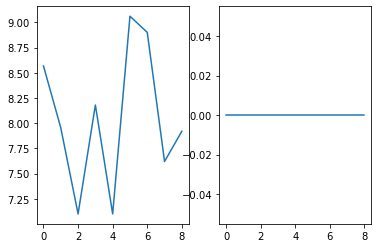

v_loss tensor(7.4151, grad_fn=<SmoothL1LossBackward0>)
readout torch.Size([299, 100])
job_waiting_feature torch.Size([299, 100])
pi_loss tensor([[86.5548],
        [83.4770],
        [83.4703],
        [86.6301],
        [90.1822],
        [83.7659],
        [88.6760],
        [88.6436],
        [90.1422],
        [82.7589],
        [90.7647],
        [82.6566],
        [82.6495],
        [86.9683],
        [88.6503],
        [83.9831],
        [87.0663],
        [88.3705],
        [89.5170],
        [88.2782],
        [87.5332],
        [88.2821],
        [83.2842],
        [86.8353],
        [83.9474],
        [91.8027],
        [89.3669],
        [85.3640],
        [90.0640],
        [88.6239],
        [90.0253],
        [90.8701],
        [86.3161],
        [86.2483],
        [90.9985],
        [84.5889],
        [84.5757],
        [84.6111],
        [87.9138],
        [88.3174],
        [90.0189],
        [90.0460],
        [90.0572],
        [83.7043],
        [85.2321],
        

KeyboardInterrupt: 

In [8]:
def main():
    env = system_manager()
    model = actor_network()

    reward_history = []
    v_history = []
    
    # network topology의 edges(GNN 예제 링크 참고)
    adjacency = torch.tensor([[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4],
                              [1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 2, 3]], dtype=torch.long)

    # for each time step
    time = 0
    while True:
        #print('---------------------------------------------------------------------------')
        node_state, link_state = env.get_state()  # 환경으로부터 실제 state를 관측해 옴(OMNeT++에서 얻어온 statistic로 대체되어야 함).
        node_state = torch.tensor(node_state, dtype=torch.float)
        link_state = torch.tensor(link_state, dtype=torch.float)
        job_waiting_state = env.get_job_waiting_vector()
        
        env.init_job_progress()
        
        # actions through multiple inferences
        scheduled_job_num = 0
        # 시스템에 job이 꽉찼거나, 스케줄할 job이 없거나, 현재 timestep에서 스케줄링한 job 개수가 10개 이상이면 그만한다.
        while env.activated_job_num < 10 and len(env.job_waiting_queue) > 0 and scheduled_job_num < 10:
            # job waiting 제일 앞에 있는 job 가져와서 스케줄링 해야 함.
            job_idx = env.assign_index()
            job = env.job_waiting_queue[0]
            subtasks = job.subtasks
            offloading_vector = []
            
            # 이 job의 모든 subtasks(layers)를 스케줄링해야 함.
            for order in range(len(subtasks)):
                network_state = Data(x=node_state, edge_attr=link_state, edge_index=adjacency)
                prob, entropy = model.pi([network_state, torch.tensor(np.array([job_waiting_state]), dtype=torch.float)])
                #print(f'prob : {prob}')
                
                m = Categorical(prob)
                node = m.sample().item()
                #print(f'node : {node}')
                offloading_vector.append(node)
                
                # state transition(환경으로부터 매번 state를 업데이트하는게 아닌, 현재 state를 기반으로 action에 해당하는 waiting만 더해줌).
                # 아래의 구체적인 코드는 이해하시기 보단 OMNeT++에서 받아온 데이터로 새로 짜시는게 빠를 것 같습니다.
                next_node_state = node_state.clone().detach()
                next_job_waiting_state = job_waiting_state.copy()
                
                next_node_state[node][5*job.index+order] += (subtasks[order].comp_demand/100) # 100으로 나누는 이유 : 이렇게 해야 액션이 한쪽 노드로 쏠리게끔 학습이 되는 것을 어느정도 방지할 수 있는 것을 확인.
                # 100으로 안나눠주면 너무 큰 값이 state에 추가되어서 inference시 가중치랑 곱해지면서 액션이 한쪽으로 확 쏠리는 걸로 예상됨.
                next_network_state = Data(x=next_node_state, edge_attr=link_state, edge_index=adjacency)
                next_job_waiting_state[5+order] = 0
                
                model.put_data([network_state, job_waiting_state, node, 0, next_network_state, next_job_waiting_state, prob[0][node].item(), entropy])
                
                node_state = next_node_state
                job_waiting_state = next_job_waiting_state
            
            scheduled_job_num += 1
            
            # job을 시스템에 스케줄링.
            env.schedule(job_idx, offloading_vector)
            env.move_job() # backlog에 있는 job을 job waiting vector로 옮기는 것.
            job_waiting_state = env.get_job_waiting_vector()
        
        
        # 이 timestep이 끝날때까지 시간을 흘려줌(제가 만든 환경이므로 이런 코드가 필요합니다. OMNeT++은 그냥 시뮬레이션 하면서 시간이 자동으로 흐르므로 필요없습니다).
        for ms in range(100):
            env.step(time)
            time += 1
        
        # 이 timestep이 끝나면, 했던 행동에 대한 reward 계산(이 tiemstep 동안 시스템에 있는 job의 진행정도)
        # 지금 보상 계산하는 과정에서 살짝 오류가 있습니다. 보상을 계산하기 전에 이번 timestep에서 어떤 job이 끝나서 없어져 버리면 그 job에 대한 진행정도를 추적할 수 없어서 0이 됩니다.
        # 여기서 보상을 계산하는 부분(즉, job의 진행정도 tracking)이 환경과 좀 관련 있기 때문에, 보상을 어떻게 계산할지를 새로 짜시는게 빠를 것 같습니다.
        per_timestep_reward = env.get_reward()

        #if per_timestep_reward == 0:
        #    per_timestep_reward = 5
        
        #print(f'reward : {per_timestep_reward}')

        if time > 100:

            reward_history = reward_history[-500:]
            reward_history.append(per_timestep_reward)


            v_history = v_history[-500:]
            v_history.append(int(model.v([network_state, torch.tensor(np.array([job_waiting_state]), dtype=torch.float)])[0]))

        if time % 1000 == 0:
            plt.subplot(1,2,1)
            plt.plot(reward_history)
            plt.subplot(1,2,2)
            plt.plot(v_history)
            plt.show()

        
        
        # 이 timestep에서 발생한 모든 샘플에 똑같은 보상 적용.
        for sample in model.data:
            sample[3] = per_timestep_reward

        if len(model.data) > 0 and time % 1000 == 0:
            model.train_net()
        
        # 새로운 job을 발생시키는 코드.
        if time%10 == 0:
            env.create_job(time)
            env.move_job()


            
            
if __name__ == '__main__':
    main()